In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

### Clustering Music Data.

The goal of this project is to experiment with clustering algorithms and determine a reasonable number of clusters in the data.
There is a goup of cells used to sort through the dataset to pick out desired genres. Skip this section to include all genres.

The data initially used in the clustering algorithm has been hand-filtered to include personal favorite sub-genres from the first 1000 most frequently listed genres. The selected sub-genres could be reduced to 4 encompassing genres (Show Tunes, Classical, Country, Rap/Pop). This filtering was done to see if the similarities in the elements of each genre is shown in the data via cluster formations. There has not yet been enough investigation within this notebook to draw any conclusions regarding this side-note.

#### Possible implementations:
    suggestion system for music sales or a streaming service.

#### Future Work:
    Improved data implementation, create a dashboard, implement as plug-in to bigger system

In [37]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

try:
    from umap import UMAP
except ModuleNotFoundError:
    !pip install umap-learn
    from umap import UMAP

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<IPython.core.display.Javascript object>

### Data: Spotify Music Data

#### Content

The "data.csv" file contains more than 170.000 songs collected from Spotify Web API, and also you can find data grouped by artist, year, or genre in the data section.


#### Primary:
- id (Id of track generated by Spotify)

#### Numerical:
- acousticness (Ranges from 0 to 1)
- danceability (Ranges from 0 to 1)
- energy (Ranges from 0 to 1)
- duration_ms (Integer typically ranging from 200k to 300k)
- instrumentalness (Ranges from 0 to 1)
- valence (Ranges from 0 to 1)
- popularity (Ranges from 0 to 100)
- tempo (Float typically ranging from 50 to 150)
- liveness (Ranges from 0 to 1)
- loudness (Float typically ranging from -60 to 0)
- speechiness (Ranges from 0 to 1)
- year (Ranges from 1921 to 2020)

#### Dummy:
- mode (0 = Minor, 1 = Major)
- explicit (0 = No explicit content, 1 = Explicit content)

#### Categorical:
- key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…)
- artists (List of artists mentioned)
- release_date (Date of release mostly in yyyy-mm-dd format, however precision of date may vary)
- name (Name of the song)

In [103]:
path = "data/data_w_genres.csv"
music = pd.read_csv(path)

<IPython.core.display.Javascript object>

Reduce the data set to songs within a reasonable range for 'duration_ms'.
This is reduced to a range of 1-7 minute songs from the previous range of (~8 seconds to ~1 hour) . This will help ensure the data is coming from actual songs and not clips, or 'hidden' tracks with a lot of dead-space in them. 

In [5]:
music["duration_ms"].describe()

count    3.253900e+04
mean     2.485982e+05
std      1.581808e+05
min      8.042000e+03
25%      1.804616e+05
50%      2.215070e+05
75%      2.815870e+05
max      4.696690e+06
Name: duration_ms, dtype: float64

<IPython.core.display.Javascript object>

In [104]:
one_to_seven_minutes = (music["duration_ms"] >= 60000) & (
    music["duration_ms"] <= 7 * 60000
)
music = music.loc[one_to_seven_minutes.values]


<IPython.core.display.Javascript object>

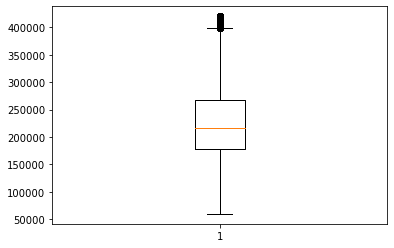

<IPython.core.display.Javascript object>

In [7]:
plt.boxplot(music["duration_ms"])
plt.show()

The box plot above shows that most ouliers have been eliminated for this column. 

The following 3 or 4 cells are used to 'hand-filter' the data to include only my selected genres.

In [8]:
item = 88
if music.genres.value_counts()[900:].index[item] in genre_list:
    print("already in list")
else:
    genre_list.append(music.genres.value_counts()[900:].index[item])
    print("added to list")

NameError: name 'genre_list' is not defined

<IPython.core.display.Javascript object>

In [960]:
music.genres.value_counts()[980:1000]

['bulgarian electronic']                                                                                                          3
['gospel singers']                                                                                                                3
['bubble trance']                                                                                                                 3
['dance pop', 'europop']                                                                                                          3
['gothic rock', 'new wave']                                                                                                       3
['american classical piano', 'classical piano']                                                                                   3
['classic garage rock', 'freakbeat']                                                                                              3
['future bass', 'kawaii future bass']                                       

<IPython.core.display.Javascript object>

In [843]:
genre_list.pop()

"['east coast hip hop', 'electro', 'gangster rap', 'hardcore hip hop', 'hip hop', 'old school hip hop', 'rap']"

<IPython.core.display.Javascript object>

In [506]:
print(genre_list)

["['contemporary country', 'country', 'country road', 'modern country rock']", "['classical soprano']", "['country', 'country rock']", "['broadway']", "['hollywood']", "['show tunes']", "['broadway', 'show tunes']", "['broadway', 'hollywood', 'show tunes']", "['hollywood', 'show tunes']", "['orchestral performance']", "['contemporary country', 'country pop']", "['classical bass']", "['contemporary country']", "['contemporary country', 'country', 'country dawn', 'country road']", "['classical tenor']", "['classical soprano', 'opera']", "['texas country']", "['country', 'country road', 'country rock']", "['country rap', 'redneck']", "['classic country pop']", "['pop rap']", "['meme rap']", "['freestyle']", "['traditional country']", "['classical performance', 'orchestral performance']", "['orchestra']", "['classic country pop', 'country', 'country rock']", "['k-rap']", "['classical cello']", "['emo rap', 'sad rap']", "['atl hip hop']", "['historic orchestral performance']", "['nyc rap']"

<IPython.core.display.Javascript object>

In [1061]:
music = music.loc[music["genres"].isin(genre_list)]
music.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.598500,0.470100,267072.000000,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000,5,1,10,['show tunes']
14,'In The Heights' Original Broadway Company,0.626667,0.547000,387293.666667,0.392667,0.000000,0.260000,-8.348667,0.312100,171.167667,0.509333,52.000000,5,1,3,"['broadway', 'show tunes']"
15,'Legally Blonde' Ensemble,0.598000,0.629667,208493.666667,0.510000,0.000000,0.251000,-10.526667,0.607667,95.090333,0.516333,51.666667,2,1,3,"['broadway', 'hollywood', 'show tunes']"
20,(G)I-DLE,0.026794,0.534000,193085.600000,0.829800,0.000002,0.168880,-3.950800,0.061040,130.417800,0.353400,76.600000,6,0,5,"['k-pop', 'k-pop girl group']"
55,1986 Omega Tribe,0.319856,0.680000,274628.000000,0.612111,0.028257,0.169333,-13.467889,0.031933,121.795222,0.834889,37.888889,9,0,18,['classic city pop']


<IPython.core.display.Javascript object>

Next, the data is checked for 'NAN' or 'NULL' values, the desired columns are selected, and if needed, a smaller sample is taken.

In [105]:
droplist = [
    "artists",
    #     "acousticness",
    #     "danceability",
    "duration_ms",
    #         "energy",
    #     "instrumentalness",
    "liveness",
    "loudness",
    "speechiness",
    "tempo",
    "valence",
    #     "popularity",
    "key",
    "mode",
    "count",
    "genres",
]

<IPython.core.display.Javascript object>

In [106]:
music.shape

(30104, 16)

<IPython.core.display.Javascript object>

In [107]:
music_df = music.copy()

music = music.drop(columns=droplist)

music.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
0,0.598500,0.470100,267072.000000,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000
1,0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,31.538462
2,0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.571429
3,0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.407407
4,0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,42.000000


<IPython.core.display.Javascript object>

In [108]:
music = music.sample(2000, random_state=1234)

<IPython.core.display.Javascript object>

In [109]:
music.isna().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
dtype: int64

<IPython.core.display.Javascript object>

Graph the data using to pairplot to observe the distributions and the relationships between columns. See if any possible clusters can be predicted.

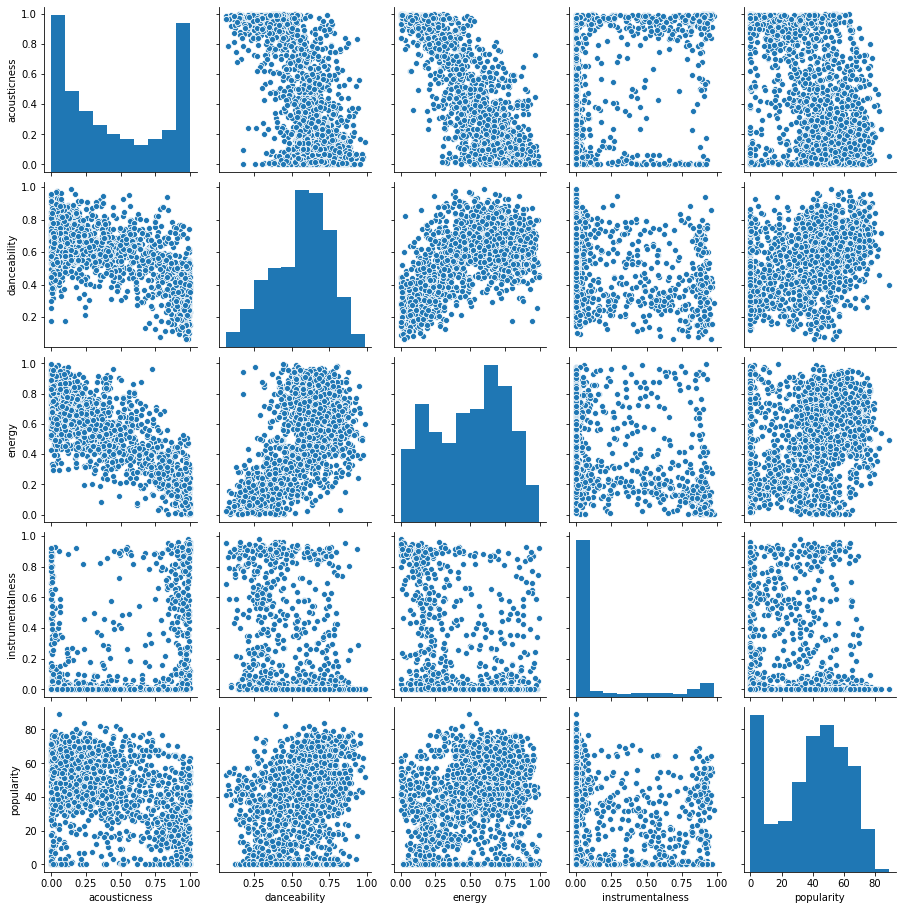

<IPython.core.display.Javascript object>

In [897]:
sns.pairplot(music)
plt.show()

Scaling the data. Scaling is a good general practice for modeling. Most of the used columns are on the same scale, from 0-1, but the 'popularity' column ranges from 0-100. Scaling is needed here to give each columns equal weight.

In [110]:
scaler = StandardScaler()
scaled = scaler.fit_transform(music)
scaled_df = pd.DataFrame(scaled, columns=music.columns)
scaled_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
0,-0.924429,0.225555,2.723482,0.839395,-0.640637,1.065729,0.884887,-0.278795,0.184780,-0.747816,0.848115
1,0.941754,-0.288078,2.148570,-0.793171,0.575032,-0.473410,-0.080472,-0.464855,0.482323,0.077188,0.416765
2,-0.738802,1.556332,0.076946,-0.190609,-0.640644,0.011255,0.657248,0.999397,0.746497,-0.000797,1.797084
3,-0.531542,1.190952,0.137772,0.362995,-0.640643,1.131224,0.023622,1.060642,-0.770784,0.472041,0.856742
4,1.393601,-1.134405,-2.231111,-1.598344,2.381447,-0.891269,-1.566659,-0.523968,-2.228308,-1.814166,0.589305


<IPython.core.display.Javascript object>

Starting with number of clusters, k, at 4. To be further evaluated below.

In [16]:
k = 4

<IPython.core.display.Javascript object>

In [17]:
kmeans = KMeans(n_clusters=k, random_state=1234)
kmeans.fit(scaled_df)

KMeans(n_clusters=4, random_state=1234)

<IPython.core.display.Javascript object>

In [18]:
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=music.columns)
centroids_df.style.background_gradient()

,acousticness,danceability,energy,instrumentalness,popularity
0,0.095922,0.612488,0.782188,0.380377,6.013994
1,0.240472,0.628801,0.652276,0.031293,47.827992
2,0.861174,0.408816,0.247528,0.777237,18.241486
3,0.838000,0.485246,0.293703,0.060609,12.314955


<IPython.core.display.Javascript object>

The first cluster is characterized by the high energy and danceability and low popularity. This could be 'Show Tunes'.

The second cluster is characterized by the high energy, danceability and popularity. This might be 'Rap/Hip-hop/pop'

The third cluster is characterized by high acoustics and intrumentals. Perhaps, 'Classical'.

The last cluster is characterized by high acoustics, and some dance ability. Maybe this is 'Country'.


Adding a label column

In [19]:
music_copy = music.copy()
music_copy["label"] = kmeans.labels_
music_copy["label"] = "Cluster: " + music_copy["label"].astype(str)
music_copy.head()

,acousticness,danceability,energy,instrumentalness,popularity,label
4144,0.115750,0.5940,0.7445,2.365000e-06,45.0,Cluster: 1
18975,0.822000,0.5060,0.3110,3.910000e-01,35.0,Cluster: 3
26340,0.186000,0.8220,0.4710,0.000000e+00,67.0,Cluster: 1
3292,0.264437,0.7594,0.6180,5.120000e-07,45.2,Cluster: 1
10459,0.993000,0.3610,0.0972,9.720000e-01,39.0,Cluster: 2


<IPython.core.display.Javascript object>

Observe the membership count of each cluster.

In [20]:
music_copy["label"].value_counts()

Cluster: 1    761
Cluster: 3    581
Cluster: 0    399
Cluster: 2    259
Name: label, dtype: int64

<IPython.core.display.Javascript object>

Using pairplot with the hue='label' to observe the clusters with respect to 2 dimensions of the data at a time.

The characteristics defined above from the background-gradient, cluster table can be seen as consistent with the plots.

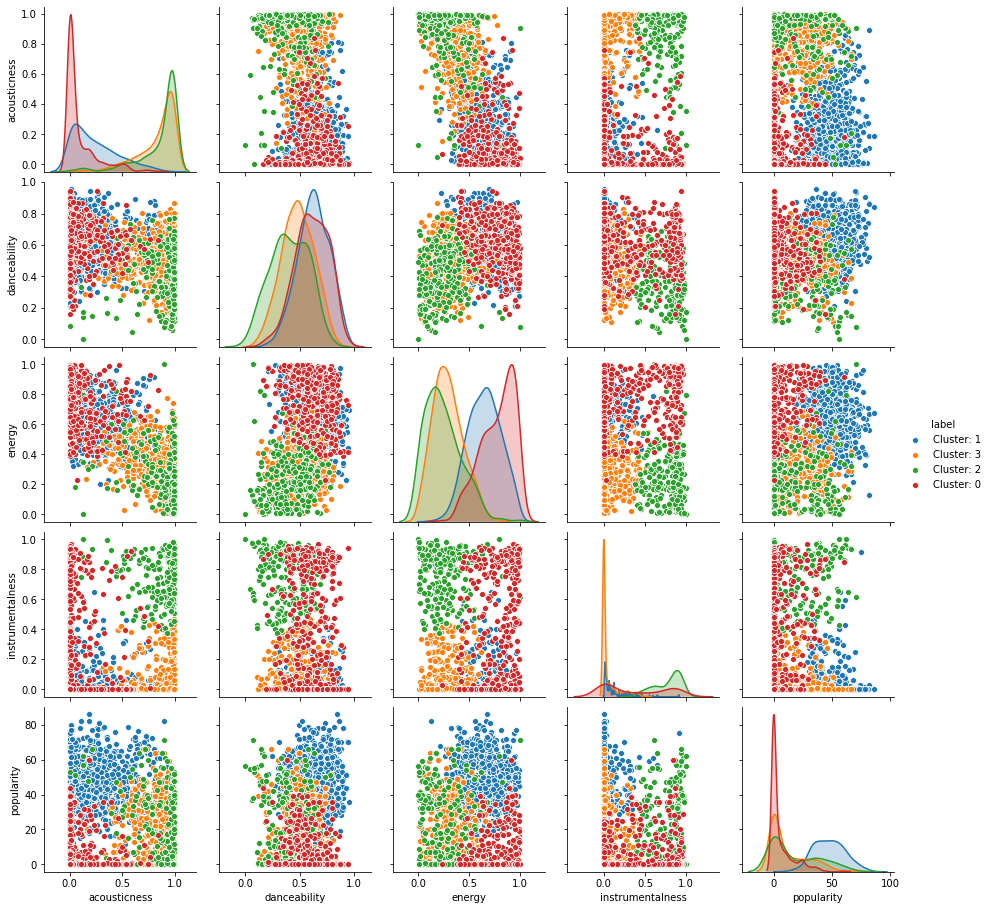

<IPython.core.display.Javascript object>

In [21]:
sns.pairplot(music_copy, hue="label")
plt.show()

There isn't any 'ground truth' to use as a method of grading accuracy, but a silhouette score will tell us how well the cluster are defined with respect to themselves. Solhouette measures the distances of elements to their assigned cluster's center vs their distances to other cluster centers. The higher the score, the better the clustering.

In [22]:
pred_2 = KMeans(n_clusters=3, random_state=1234).fit_predict(scaled_df)
pred_3 = KMeans(n_clusters=4, random_state=1234).fit_predict(scaled_df)
pred_4 = KMeans(n_clusters=5, random_state=1234).fit_predict(scaled_df)

print(
    "Silhouette score for three cluster k-means: {}".format(
        metrics.silhouette_score(scaled_df, pred_2, metric="euclidean")
    )
)
print(
    "Silhouette score for four cluster k-means: {}".format(
        metrics.silhouette_score(scaled_df, pred_3, metric="euclidean")
    )
)
print(
    "Silhouette score for five cluster k-means: {}".format(
        metrics.silhouette_score(scaled_df, pred_4, metric="euclidean")
    )
)

Silhouette score for three cluster k-means: 0.3101967551428876
Silhouette score for four cluster k-means: 0.31319940485163933
Silhouette score for five cluster k-means: 0.2974077452717408


<IPython.core.display.Javascript object>

The next algorithm to be tested is the Gaussian Mixture Model. The n_components parameter will be set to 4 in this run of the algorithm, like in K-Means algorithm above. It is worth mentioning the 'eulcidean' distance metric that is being used in this algorithm, as it was in the K-Means algorithm above.

In [23]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=4, random_state=1234)

# Fit model
gmm_cluster.fit(scaled_df)

GaussianMixture(n_components=4, random_state=1234)

<IPython.core.display.Javascript object>

Reverse the scaling, find the mean for each cluster, and put them in a data frame with a background gradient to help visualize the results and define some characteristics of each cluster.

In [26]:
means = scaler.inverse_transform(gmm_cluster.means_)
means_df = pd.DataFrame(means, columns=music.columns)
means_df.style.background_gradient()

,acousticness,danceability,energy,instrumentalness,popularity
0,0.393845,0.598459,0.558782,0.000210,34.195967
1,0.978828,0.459965,0.246341,0.331057,0.000435
2,0.511552,0.516598,0.482274,0.330056,27.700623
3,0.005080,0.617282,0.835371,0.565128,2.732108


<IPython.core.display.Javascript object>

Add a cluster label column, observe the membership count of the clusters, and plot the results using pair plot. Use the plot to observe the characteristic defined above in the graded, cluster mean table. Notice that the cluster characteristic aren't quite the same as the characteristics of the clusters formed using K-Means.

In [55]:
labels = gmm_cluster.predict(scaled_df)
music_copy = music.copy()
music_copy["label"] = labels
music_copy["label"] = "Cluster: " + music_copy["label"].astype(str)
music_copy.head()

,acousticness,danceability,energy,instrumentalness,popularity,label
4144,0.115750,0.5940,0.7445,2.365000e-06,45.0,Cluster: 0
18975,0.822000,0.5060,0.3110,3.910000e-01,35.0,Cluster: 2
26340,0.186000,0.8220,0.4710,0.000000e+00,67.0,Cluster: 0
3292,0.264437,0.7594,0.6180,5.120000e-07,45.2,Cluster: 0
10459,0.993000,0.3610,0.0972,9.720000e-01,39.0,Cluster: 2


<IPython.core.display.Javascript object>

In [28]:
music_copy["label"].value_counts()

Cluster: 0    881
Cluster: 2    723
Cluster: 1    219
Cluster: 3    177
Name: label, dtype: int64

<IPython.core.display.Javascript object>

C:\Users\capcl\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


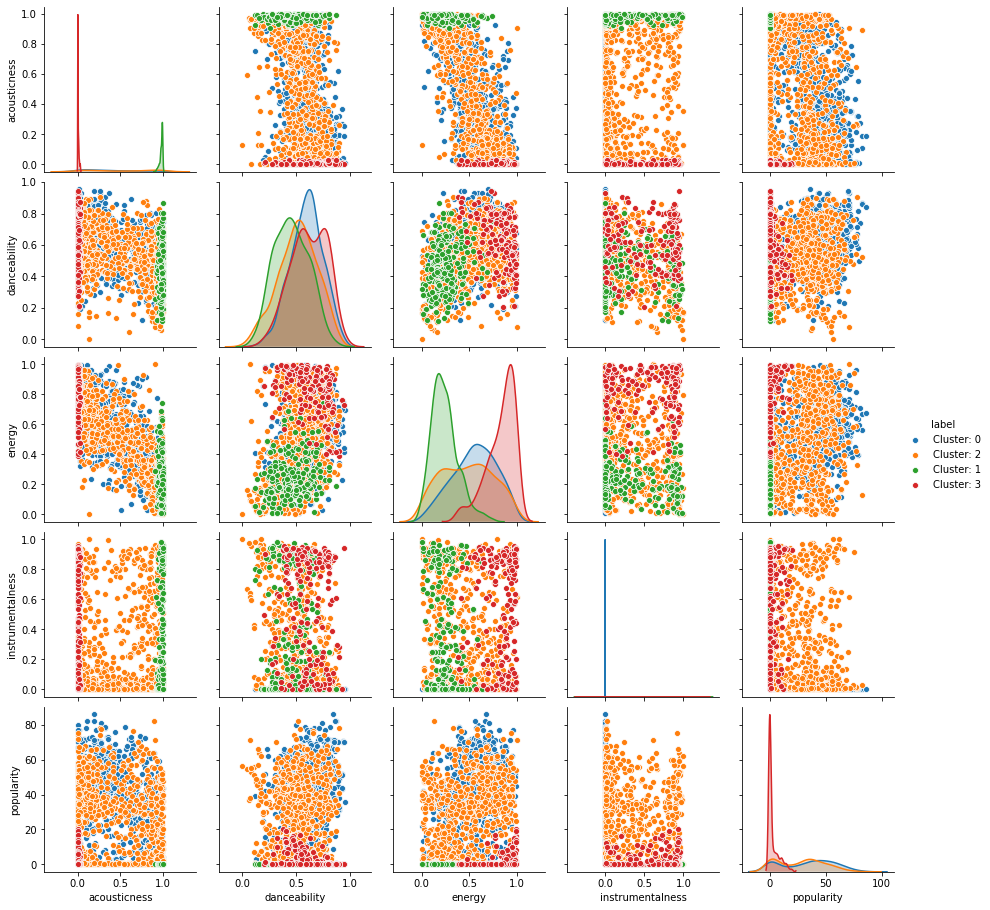

<IPython.core.display.Javascript object>

In [29]:
sns.pairplot(music_copy, hue="label")
plt.show()

In [56]:
pred_2 = GaussianMixture(n_components=3, random_state=1234).fit_predict(scaled_df)
pred_3 = GaussianMixture(n_components=4, random_state=1234).fit_predict(scaled_df)
pred_4 = GaussianMixture(n_components=5, random_state=1234).fit_predict(scaled_df)

print(
    "Silhouette score for three cluster GMM: {}".format(
        metrics.silhouette_score(scaled_df, pred_2, metric="euclidean")
    )
)
print(
    "Silhouette score for four cluster GMM: {}".format(
        metrics.silhouette_score(scaled_df, pred_3, metric="euclidean")
    )
)
print(
    "Silhouette score for five cluster GMM: {}".format(
        metrics.silhouette_score(scaled_df, pred_4, metric="euclidean")
    )
)

Silhouette score for three cluster GMM: 0.04492663472468189
Silhouette score for four cluster GMM: 0.04777170181156275
Silhouette score for five cluster GMM: 0.03052910063549023


<IPython.core.display.Javascript object>

##### This didn't score very well! 

As expected the silhouette score is much lower. The Gaussian Mixture aglorithm is more permissive to overlapping in the clusters. This can be good or bad depending on the data and the intent. 

#### DBSCAN

This clustering algorithm returns a number of clusters based on the input parameters.
* epsilon is like the radius of the cluster
* min_samples controls the minimum number of elements required to form a cluster.
* the distance metric used here is 'euclidean', the same as above.

In [76]:
dbscan = DBSCAN(eps = 0.3, min_samples =7, metric = 'euclidean')
dbscan.fit(scaled_df)


DBSCAN(eps=0.3, min_samples=7)

<IPython.core.display.Javascript object>

In [77]:
music_copy = music.copy()
music_copy["label"] = dbscan.labels_
music_copy["label"] = "Cluster: " + music_copy["label"].astype(str)
music_copy.head()

,acousticness,danceability,energy,instrumentalness,popularity,label
4144,0.115750,0.5940,0.7445,2.365000e-06,45.0,Cluster: -1
18975,0.822000,0.5060,0.3110,3.910000e-01,35.0,Cluster: -1
26340,0.186000,0.8220,0.4710,0.000000e+00,67.0,Cluster: -1
3292,0.264437,0.7594,0.6180,5.120000e-07,45.2,Cluster: -1
10459,0.993000,0.3610,0.0972,9.720000e-01,39.0,Cluster: -1


<IPython.core.display.Javascript object>

In [78]:
dbscan_clusters = music_copy[music_copy["label"] != "Cluster: -1"]
dbscan_clusters["label"].value_counts()

Cluster: 0    92
Cluster: 6    30
Cluster: 4    24
Cluster: 1    16
Cluster: 3    15
Cluster: 2    15
Cluster: 7     7
Cluster: 5     7
Name: label, dtype: int64

<IPython.core.display.Javascript object>

In [80]:
clst_avgs = dbscan_clusters.groupby("label").mean()
clst_avgs.style.background_gradient()

,acousticness,danceability,energy,instrumentalness,popularity
label,,,,,
Cluster: 0,0.962285,0.381701,0.211961,0.015924,0.629846
Cluster: 1,0.111063,0.760774,0.648332,0.006431,58.508369
Cluster: 2,0.083841,0.790113,0.685610,0.007793,44.827977
Cluster: 3,0.005403,0.537795,0.948478,0.873856,4.497516
Cluster: 4,0.012721,0.795203,0.850603,0.875399,0.591667
Cluster: 5,0.355013,0.636746,0.582055,0.005122,46.560550
Cluster: 6,0.944313,0.605068,0.213060,0.017949,0.522466
Cluster: 7,0.900435,0.519750,0.276274,0.002153,18.059524


<IPython.core.display.Javascript object>

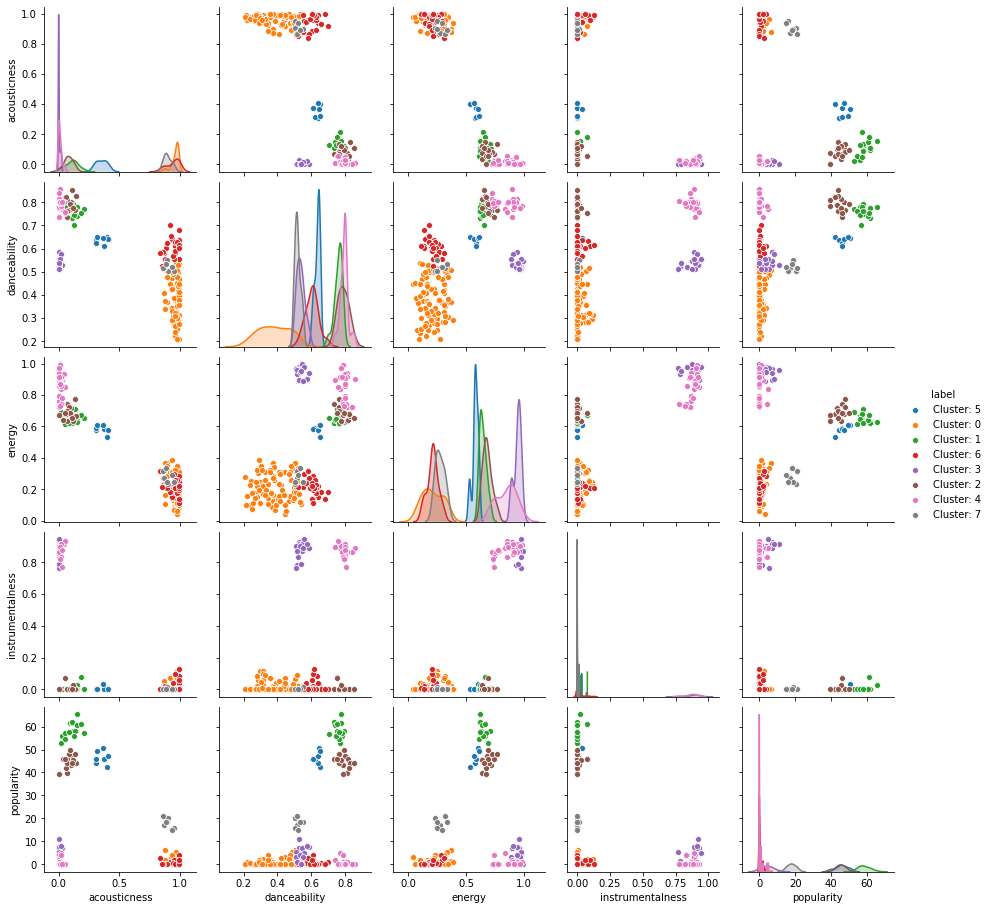

<IPython.core.display.Javascript object>

In [79]:
sns.pairplot(dbscan_clusters, hue="label")
plt.show()

The membership counts of the clusters do not account for all the sample in the data. There is a large portion that doesn't make the cut to be clustered given the parameters chosen for this run of the DBSCAN algorithm.

In the following cells the k-means and gaussian mixture algorithms are investigated. Dimension reductions are first made with PCA prior to clustering. Next, UMAP is used. These dimension reducing techniques help improve the clustering process.

Since dimension reduction is to be done before cluster, The data set will be reset, and more dimension will be kept. 

In [112]:
music = pd.read_csv(path)

<IPython.core.display.Javascript object>

In [113]:
one_to_seven_minutes = (music["duration_ms"] >= 60000) & (
    music["duration_ms"] <= 7 * 60000
)
music = music.loc[one_to_seven_minutes.values]

droplist = [
    "artists",
    #     "acousticness",
    #     "danceability",
    #     "duration_ms",
    #         "energy",
    #     "instrumentalness",
    #     "liveness",
    #     "loudness",
    #     "speechiness",
    #     "tempo",
    #     "valence",
    #     "popularity",
    "key",
    "mode",
    "count",
    "genres",
]

music_df = music.copy()

music = music.drop(columns=droplist)

<IPython.core.display.Javascript object>

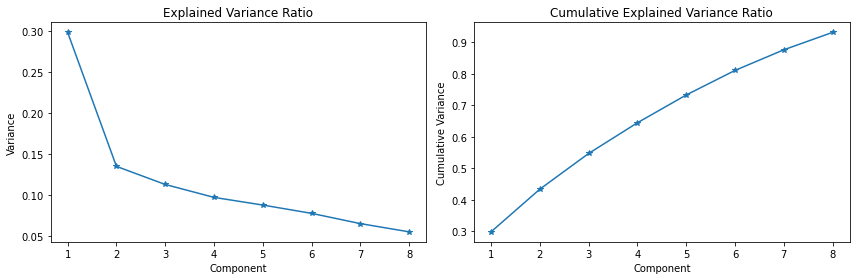

<IPython.core.display.Javascript object>

In [111]:
# Creating more than 2 points for the plot
pca_8 = PCA(8).fit(scaled)

expl_var = pca_8.explained_variance_ratio_
cumulative_var = np.cumsum(expl_var)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(np.arange(1, 9), expl_var, "-*")
axes[0].set_title("Explained Variance Ratio")
axes[0].set_xlabel("Component")
axes[0].set_ylabel("Variance")

axes[1].plot(np.arange(1, 9), cumulative_var, "-*")
axes[1].set_title("Cumulative Explained Variance Ratio")
axes[1].set_xlabel("Component")
axes[1].set_ylabel("Cumulative Variance")

plt.tight_layout()
plt.show()

It looks as though a grand majority of the variance can be explained with 2 components, but we will go with 4, where it looks to explain about 90% of the variance, and we see how that works out.

In [114]:
# Make sure the number of rows divides evenly into four samples.
rows = scaled_df.shape[0] - scaled_df.shape[0] % 2
X_std = scaled_df.iloc[:rows, :]

<IPython.core.display.Javascript object>

In [124]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes, and the
# try different 'n'-feature PCA for the actual clustering.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

pca2 = PCA(n_components=2)
G_pca = pca2.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
# X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
#     X_std, X_pca, test_size=0.5, random_state=123
# )

X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_pca, G_pca, test_size=0.5, random_state=123
)


# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([(X_half1, X_pcahalf1), (X_half2, X_pcahalf2)]):

    # Put the features into ypred.
    ypred["pca_f1" + "_sample" + str(counter)] = data[1][:, 0]
    ypred["pca_f2" + "_sample" + str(counter)] = data[1][:, 1]

    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[0])
        ypred["clust" + str(nclust) + "_sample" + str(counter)] = pred

<IPython.core.display.Javascript object>

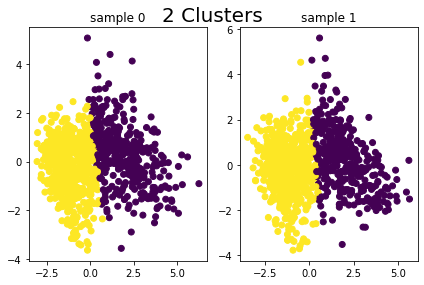

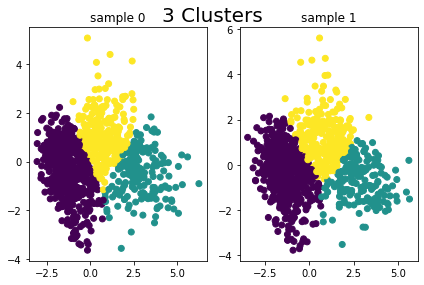

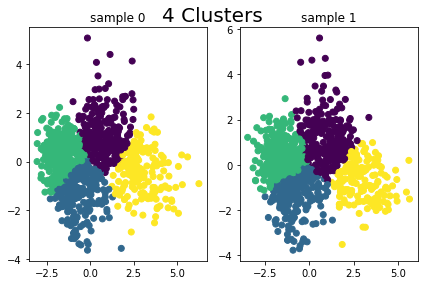

<IPython.core.display.Javascript object>

In [125]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):

    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)

    # Make a plot for each sample.
    for i in range(2):

        # PCA-created features.
        x_sub = ypred["pca_f1_sample{}".format(i)]
        y_sub = ypred["pca_f2_sample{}".format(i)]

        # Cluster assignments.
        c = ypred["clust{}_sample{}".format(cluster, i)]

        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title("sample {}".format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()

    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle("{} Clusters".format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

In [126]:
# pred_3 = KMeans(n_clusters=2, random_state=1234).fit_predict(scaled)
# pred_4 = KMeans(n_clusters=3, random_state=1234).fit_predict(scaled)
# pred_5 = KMeans(n_clusters=4, random_state=1234).fit_predict(scaled)

pred_3 = KMeans(n_clusters=2, random_state=1234).fit_predict(X_pca)
pred_4 = KMeans(n_clusters=3, random_state=1234).fit_predict(X_pca)
pred_5 = KMeans(n_clusters=4, random_state=1234).fit_predict(X_pca)

print(
    "Silhouette score for two cluster k-means: {}".format(
        metrics.silhouette_score(X_pca, pred_3, metric="euclidean")
    )
)
print(
    "Silhouette score for three cluster k-means: {}".format(
        metrics.silhouette_score(X_pca, pred_4, metric="euclidean")
    )
)
print(
    "Silhouette score for four cluster k-means: {}".format(
        metrics.silhouette_score(X_pca, pred_5, metric="euclidean")
    )
)

Silhouette score for two cluster k-means: 0.46254726956160264
Silhouette score for three cluster k-means: 0.4093116959278815
Silhouette score for four cluster k-means: 0.3875562885808761


<IPython.core.display.Javascript object>

It turns out the best silhouette scores come from a 2-feature PCA as an input to the k-means clustering. Although more variance is explained with more features, the clustering doesn't do as well in much higher dimensions. This may be an example of where using a 'euclidean' distance metric has shows its short-comings.

In [127]:
for counter, data in enumerate([(X_half1, X_pcahalf1), (X_half2, X_pcahalf2)]):

    # Put the features into ypred.
    ypred["pca_f1" + "_sample" + str(counter)] = data[1][:, 0]
    ypred["pca_f2" + "_sample" + str(counter)] = data[1][:, 1]

    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = GaussianMixture(n_components=nclust, random_state=123).fit_predict(
            data[0]
        )
        ypred["clust" + str(nclust) + "_sample" + str(counter)] = pred

<IPython.core.display.Javascript object>

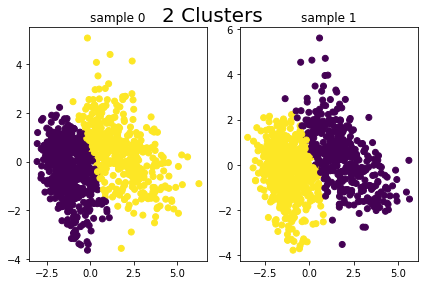

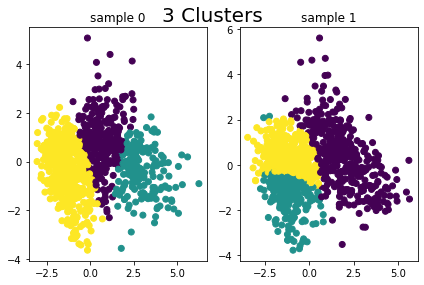

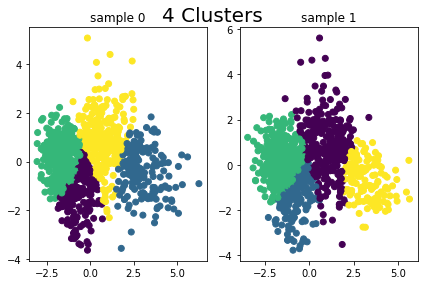

<IPython.core.display.Javascript object>

In [128]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):

    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)

    # Make a plot for each sample.
    for i in range(2):

        # PCA-created features.
        x_sub = ypred["pca_f1_sample{}".format(i)]
        y_sub = ypred["pca_f2_sample{}".format(i)]

        # Cluster assignments.
        c = ypred["clust{}_sample{}".format(cluster, i)]

        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title("sample {}".format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()

    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle("{} Clusters".format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

In [130]:
pred_3 = GaussianMixture(n_components=3, random_state=123).fit_predict(X_pca)
pred_4 = GaussianMixture(n_components=4, random_state=123).fit_predict(X_pca)
pred_5 = GaussianMixture(n_components=5, random_state=123).fit_predict(X_pca)

print(
    "Silhouette score for three cluster GMM: {}".format(
        metrics.silhouette_score(X_pca, pred_3, metric="euclidean")
    )
)
print(
    "Silhouette score for four cluster GMM: {}".format(
        metrics.silhouette_score(X_pca, pred_4, metric="euclidean")
    )
)
print(
    "Silhouette score for five cluster GMM: {}".format(
        metrics.silhouette_score(X_pca, pred_5, metric="euclidean")
    )
)

Silhouette score for three cluster GMM: 0.331587223824803
Silhouette score for four cluster GMM: 0.36281340261139405
Silhouette score for five cluster GMM: 0.31908820588572423


<IPython.core.display.Javascript object>

Using PCA prior to GMM clustering has dramatically improved the silhouette scores by almost .30.

Next, UMAP will be used both to reduce the input data, and for visualization. Then, we can compare the results to the PCA reduce clustering models. UMAP has a lot more parameters to tune, but we will test (2,3,4) components to start, and move on to the other parameters later.

In [131]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Reduce data with UMAP and use a 2 component 
# UMAP solution for visualization.
umap = UMAP(n_components=2)
X_umap = umap.fit_transform(X_std)

umap2 = UMAP(n_components=2)
G_umap = umap2.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_umaphalf1, X_umaphalf2 = train_test_split(
    X_umap, G_umap, test_size=0.5, random_state=123
)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the UMAP-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# UMAP solution in the data frame.
for counter, data in enumerate([(X_half1, X_umaphalf1), (X_half2, X_umaphalf2)]):

    # Put the features into ypred.
    ypred["umap_f1" + "_sample" + str(counter)] = data[1][:, 0]
    ypred["umap_f2" + "_sample" + str(counter)] = data[1][:, 1]

    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=1234).fit_predict(data[0])
        ypred["clust" + str(nclust) + "_sample" + str(counter)] = pred

<IPython.core.display.Javascript object>

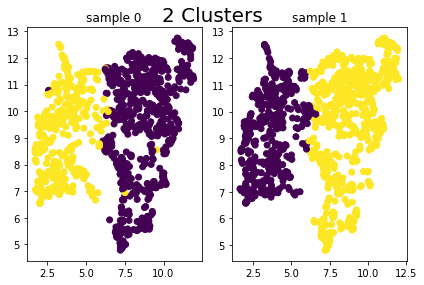

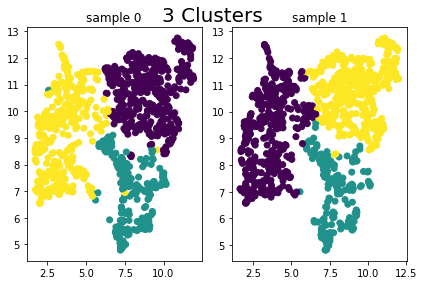

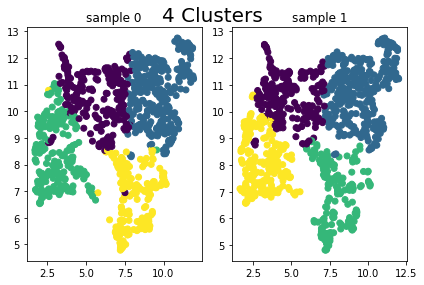

<IPython.core.display.Javascript object>

In [132]:
# For each  number of clusters, plot the clusters using the
# umap features for each sample.
for cluster in range(2, 5):

    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)

    # Make a plot for each sample.
    for i in range(2):

        # UMAP-created features.
        x_sub = ypred["umap_f1_sample{}".format(i)]
        y_sub = ypred["umap_f2_sample{}".format(i)]

        # Cluster assignments.
        c = ypred["clust{}_sample{}".format(cluster, i)]

        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title("sample {}".format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()

    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle("{} Clusters".format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

In [133]:
pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_umap)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_umap)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_umap)

print(
    "Silhouette score for two cluster k-means: {}".format(
        metrics.silhouette_score(X_umap, pred_2, metric="euclidean")
    )
)
print(
    "Silhouette score for three cluster k-means: {}".format(
        metrics.silhouette_score(X_umap, pred_3, metric="euclidean")
    )
)
print(
    "Silhouette score for four cluster k-means: {}".format(
        metrics.silhouette_score(X_umap, pred_4, metric="euclidean")
    )
)

Silhouette score for two cluster k-means: 0.4830545485019684
Silhouette score for three cluster k-means: 0.49770641326904297
Silhouette score for four cluster k-means: 0.45015931129455566


<IPython.core.display.Javascript object>

The UMAP reduced, k-means clusters do the best with 3 clusters.

In [134]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by GMM,
# and the UMAP-derived features for graphing. We use GMM to fit a
# model to the data, then store the predicted values and the two-feature
# UMAP solution in the data frame.
for counter, data in enumerate([(X_half1, X_umaphalf1), (X_half2, X_umaphalf2)]):

    # Put the features into ypred.
    ypred["umap_f1" + "_sample" + str(counter)] = data[1][:, 0]
    ypred["umap_f2" + "_sample" + str(counter)] = data[1][:, 1]

    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = GaussianMixture(n_components=nclust, random_state=123).fit_predict(
            data[0]
        )
        ypred["clust" + str(nclust) + "_sample" + str(counter)] = pred

<IPython.core.display.Javascript object>

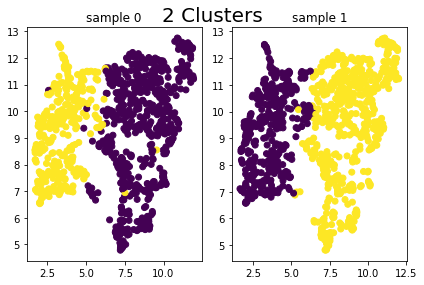

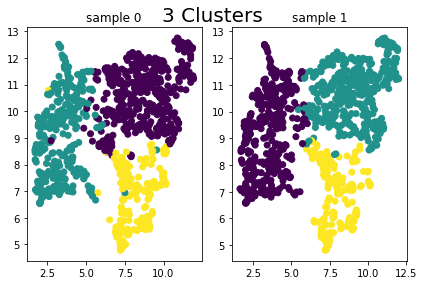

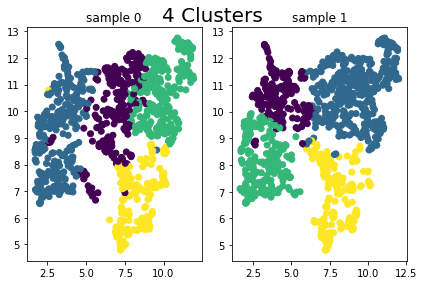

<IPython.core.display.Javascript object>

In [135]:
# For each  number of clusters, plot the clusters using the
# umap features for each sample.
for cluster in range(2, 5):

    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)

    # Make a plot for each sample.
    for i in range(2):

        # UMAP-created features.
        x_sub = ypred["umap_f1_sample{}".format(i)]
        y_sub = ypred["umap_f2_sample{}".format(i)]

        # Cluster assignments.
        c = ypred["clust{}_sample{}".format(cluster, i)]

        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title("sample {}".format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()

    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle("{} Clusters".format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

In [136]:
pred_2 = GaussianMixture(n_components=2, random_state=123).fit_predict(X_umap)
pred_3 = GaussianMixture(n_components=3, random_state=123).fit_predict(X_umap)
pred_4 = GaussianMixture(n_components=4, random_state=123).fit_predict(X_umap)

print(
    "Silhouette score for two cluster GMM: {}".format(
        metrics.silhouette_score(X_umap, pred_2, metric="euclidean")
    )
)
print(
    "Silhouette score for three cluster GMM: {}".format(
        metrics.silhouette_score(X_umap, pred_3, metric="euclidean")
    )
)
print(
    "Silhouette score for four cluster GMM: {}".format(
        metrics.silhouette_score(X_umap, pred_4, metric="euclidean")
    )
)

Silhouette score for two cluster GMM: 0.47784683108329773
Silhouette score for three cluster GMM: 0.48597708344459534
Silhouette score for four cluster GMM: 0.4248363673686981


<IPython.core.display.Javascript object>

The UMAP reduced, GMM clusters produced a better silhouette score than the other GMM outcomes, with the best being 3 clusters.